# SLEP 014 Benchmark results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['lines.linewidth'] = 2.5

def plot_results(df, x, hue=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    sns.barplot(x=x, y='peak_memory', data=df, ax=ax1, hue=hue)
    ax1.set_title("Peak memory")
    sns.barplot(x=x, y='time', data=df, ax=ax2, hue=hue)
    ax2.set_title("Time")

# Custom sparse example

```py
class SillyVectorizer(TransformerMixin, BaseEstimator):
    def __init__(self, n_features_out=1_000, density=0.01):
        self.n_features_out = n_features_out
        self.density = density

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data_wrap = _DataTransformer(X, needs_feature_names_in=False)

        n_samples = len(X)
        X_output = sparse.rand(n_samples, self.n_features_out,
                               density=self.density, random_state=0)
        output = data_wrap.transform(X_output, self.get_feature_names)
        return output

    def get_feature_names(self):
        return [f'col_{i}' for i in range(self.n_features_out)]


class PassthroughTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        X = check_array(X, accept_sparse=True)
        # do some fitting
        return self

    def transform(self, X):
        data_wrap = _DataTransformer(X)
        X = check_array(X, accept_sparse=True)
        # typically does some math
        return data_wrap.transform(X)
        
        
def main(density, array_out)
    set_config(array_out=array_out)

    n_samples = 100_000
    X = [None] * n_samples

    pipe = make_pipeline(SillyVectorizer(density=density),
                         PassthroughTransformer())
    pipe.fit(X)
    output = pipe.transform(X)

```

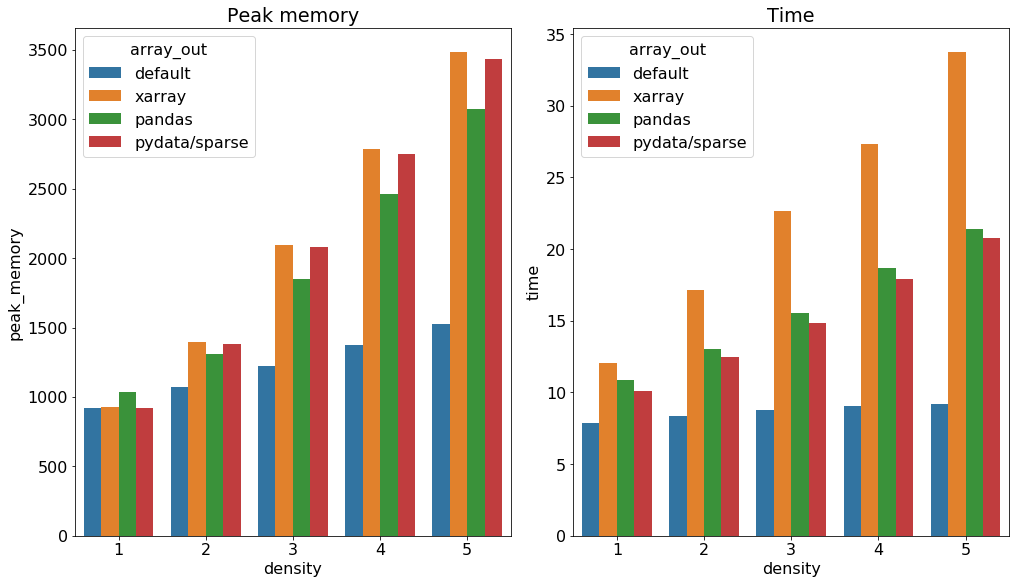

In [8]:
df = pd.read_json("results/bench_sparse_custom.json")
df['density'] = (df['density'] * 10).astype(int)
plot_results(df, x='density', hue='array_out')


## Simple sparse pipeline with chained scalers

`maxabs_scalers` is the number of scalers to chain together in pipeline

```py
data = fetch_20newsgroups(subset='train')
set_config(array_out=array_out)

estimators = ([CountVectorizer()] +
              [MaxAbsScaler() for _ in range(maxabs_scalers)])
pipe = make_pipeline(*estimators)
output = pipe.fit_transform(data.data)
```

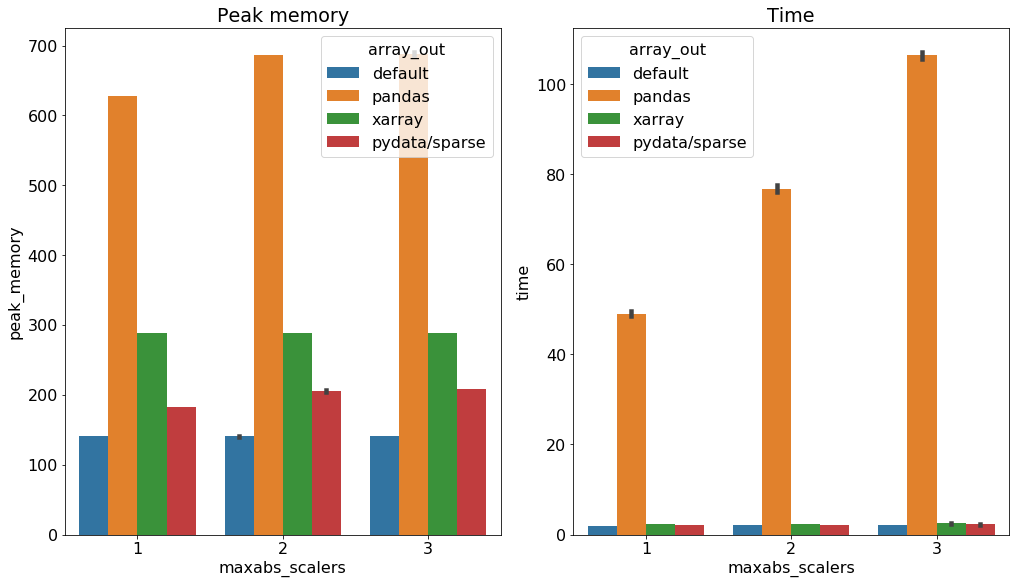

In [69]:
df = pd.read_json("results/bench_sparse_maxabsscaler.json")
plot_results(df, x='maxabs_scalers', hue='array_out')

## Sparse pipeline with text input

`max_features` is passed to `CountVectorizer`

```py
data = fetch_20newsgroups(subset='train')
set_config(array_out=array_out)
pipe = make_pipeline(CountVectorizer(max_features=max_features),
                     TfidfTransformer(),
                     SGDClassifier(random_state=42))
pipe.fit(data.data, data.target)
```

`array_out='pydata/sparse'` uses pydata.sparse (with no feature names). Without the feature names, it uses less memory than xarray.

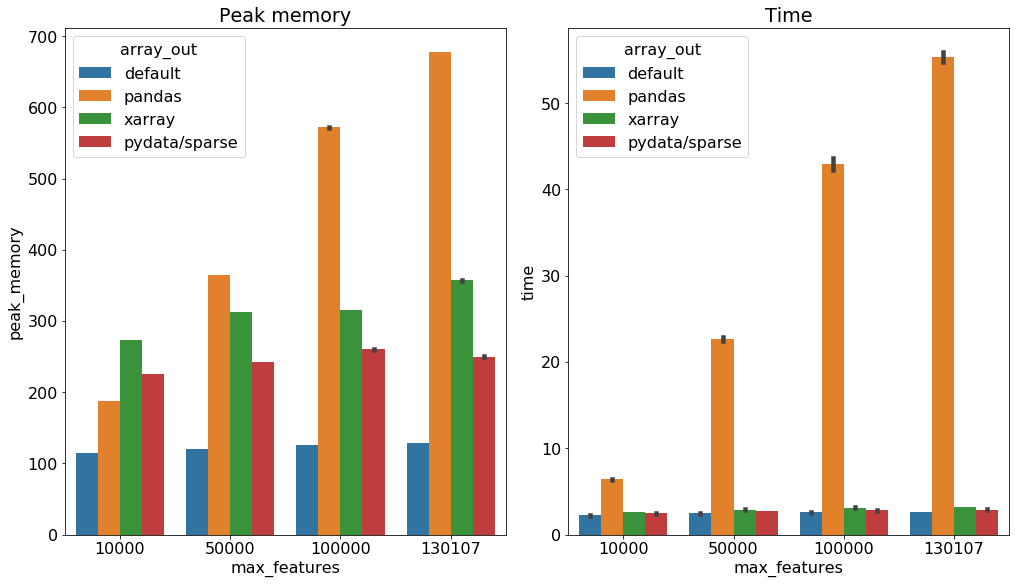

In [71]:
df = pd.read_json("results/bench_sparse_text_input.json")
plot_results(df, x='max_features', hue='array_out')

## Simple dense pipeline

```py
X, y = fetch_openml(data_id=1476, return_X_y=True, as_frame=True)

set_config(array_out=array_out)
pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=64),
                     SelectKBest(k=30),
                     Ridge())
pipe.fit(X, y)
output = pipe[:-1].transform(X)
```

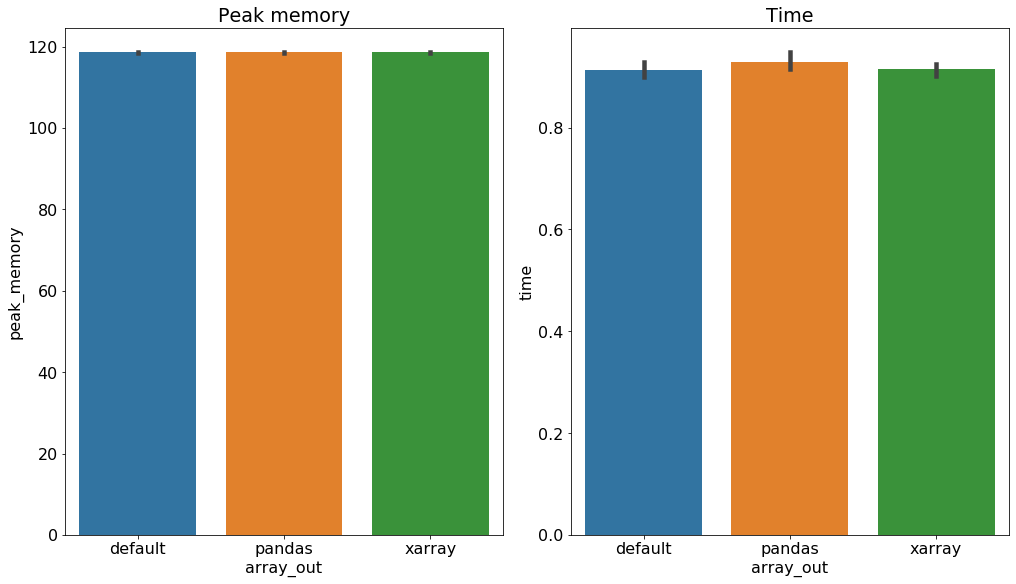

In [64]:
df = pd.read_json("results/bench_dense.json")
plot_results(df, x='array_out')

## Dense pipeline with column transformer

```py
X, y = fetch_openml(data_id=1590, return_X_y=True, as_frame=True)

set_config(array_out=array_out)
cat_prep = make_pipeline(
    SimpleImputer(fill_value='sk_missing',
                    strategy='constant'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

prep = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include='number')),
    (cat_prep, make_column_selector(dtype_include='category'))
)

pipe = make_pipeline(prep,
                        SelectKBest(),
                        DecisionTreeClassifier(random_state=42))
pipe.fit(X, y)
output = pipe[:-1].transform(X)
```

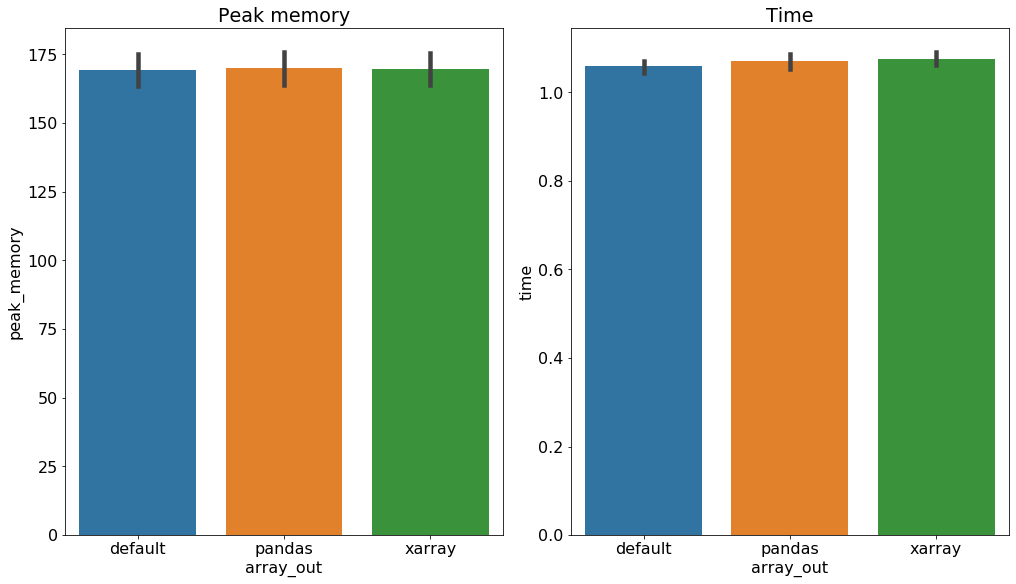

In [66]:
df = pd.read_json("results/bench_column_transform.json")
plot_results(df, x='array_out')

## Dense pipeline with many repeated transformations

`minmax_scalers` is the number of MinMaxScalers in the pipeline

```py
n_features = 200
X, _ = make_regression(n_samples=300_000, n_features=n_features,
                        random_state=42)
df = pd.DataFrame(X, columns=[f"col_{i}" for i in range(n_features)])
set_config(array_out=array_out)

pipe = make_pipeline(*[MinMaxScaler() for _ in range(minmax_scalers)])
output = pipe.fit_transform(df)
```

It is a little strange how the default uses more memory for `minmax_scalers>=3`

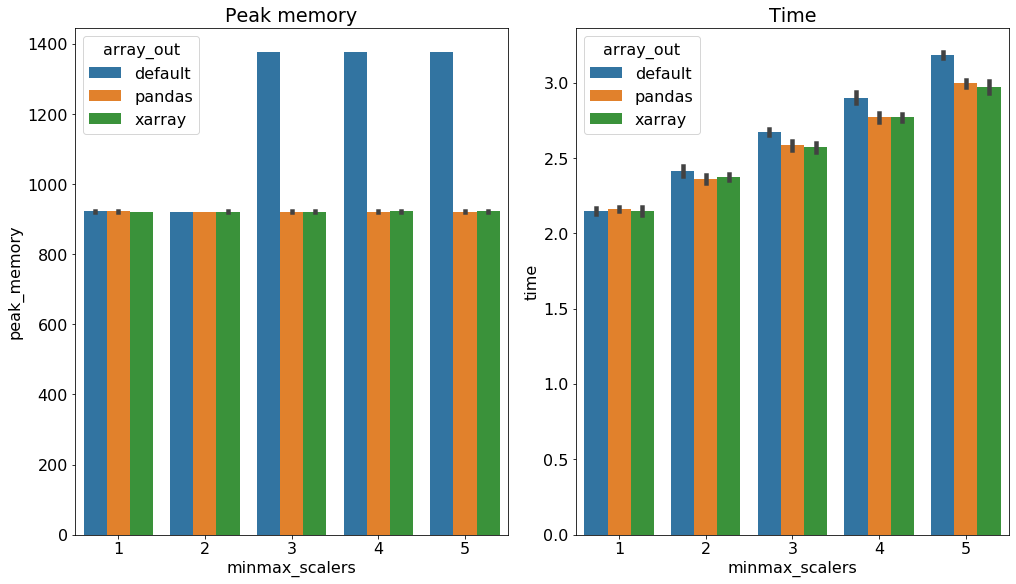

In [67]:
df = pd.read_json("results/bench_dense_minmaxscaler.json")
plot_results(df, x='minmax_scalers', hue='array_out')